In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')


In [136]:
df = pd.read_csv("train.csv", index_col=0).drop(["Surname", "CustomerId"], axis=1)
test = pd.read_csv("test.csv", index_col=0).drop(["Surname", "CustomerId"], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [137]:
def featuer_engineering(data):
    # Age
    data["Age_order_by_quantity"] = pd.qcut(data["Age"], q = 5)
    data["Age_groups"] = pd.cut(data["Age"], bins = 3)
    data["Gender_IsActive"] = df["Gender"]
    data["Log(AGE)"] = (np.log(data["Age"]))
    data["Age dagree = 4"] = data["Age"] ** 4 

    # Balance
    data["Balance_group"] = pd.cut(data["Balance"] , bins=5)
    one = OneHotEncoder()
    encoded = one.fit_transform(df[['NumOfProducts']])
    df_encoded = pd.DataFrame(encoded.toarray(), columns=one.get_feature_names_out(['NumOfProducts']))

    data = pd.concat([data, df_encoded], axis=1)



    # Number of Products
    data["IsActive + Products"] = data["NumOfProducts"] * (5 * data["IsActiveMember"])
    # age_bins = [18, 32, 42, 92]
    # age_labels = ["Young", "Medium", "Senior"]

    # data["AgeGroup"] = pd.cut(data["Age"], bins=age_bins, labels=age_labels)
    
    # data["Country_male_age_isactive"] = data["Geography"].astype(str) + "_" + data["Gender"].astype(str) + "_" + data["AgeGroup"].astype(str) + df["IsActiveMember"].astype(str)

In [138]:
def encoder(data):
    one = OneHotEncoder()
    encoded = one.fit_transform(df[['NumOfProducts']])
    df_encoded = pd.DataFrame(encoded.toarray(), columns=one.get_feature_names_out(['NumOfProducts']))

    data = pd.concat([data, df_encoded], axis=1)
    return data

In [139]:
df["Age"].describe()

count    165034.000000
mean         38.125888
std           8.867205
min          18.000000
25%          32.000000
50%          37.000000
75%          42.000000
max          92.000000
Name: Age, dtype: float64

In [140]:
WoE_values = {}

def WoE(data, col, target):
    event = data[target].sum()
    non_event = len(data) - event

    grouped = data.groupby(col)[target].agg(['sum', 'count'])
    grouped['non_events'] = grouped['count'] - grouped['sum']
    
    grouped['event_rate'] = grouped['sum'] / event
    grouped['non_event_rate'] = grouped['non_events'] / non_event
    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    woe_dict = grouped['woe'].to_dict()
    WoE_values[col] = woe_dict

In [141]:
def featuer_engineering_woe(data):
    for i in WoE_values:
        data[i + "_WoE"] = data[i].map(WoE_values[i]).astype(float)
        

In [142]:
featuer_engineering(df)
featuer_engineering(test)
# df = encoder(df)
# test = encoder(test)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   CreditScore            165034 non-null  int64   
 1   Geography              165034 non-null  object  
 2   Gender                 165034 non-null  object  
 3   Age                    165034 non-null  float64 
 4   Tenure                 165034 non-null  int64   
 5   Balance                165034 non-null  float64 
 6   NumOfProducts          165034 non-null  int64   
 7   HasCrCard              165034 non-null  float64 
 8   IsActiveMember         165034 non-null  float64 
 9   EstimatedSalary        165034 non-null  float64 
 10  Exited                 165034 non-null  int64   
 11  Age_order_by_quantity  165034 non-null  category
 12  Age_groups             165034 non-null  category
 13  Gender_IsActive        165034 non-null  object  
 14  Log(AGE)               16

In [144]:
WoE(df, "Geography", "Exited")
WoE(df, "Gender", "Exited")
WoE(df, "Age_order_by_quantity", "Exited")
WoE(df, "Age_groups", "Exited")
WoE(df, "Balance_group", "Exited")
WoE(df, "NumOfProducts", "Exited")

In [145]:
featuer_engineering_woe(df)
featuer_engineering_woe(test)
df["Age_groups_WoE /0.5"] = df["Age_groups_WoE"] // 0.5
test["Age_groups_WoE /0.5"] = test["Age_groups_WoE"] // 0.5


<Axes: >

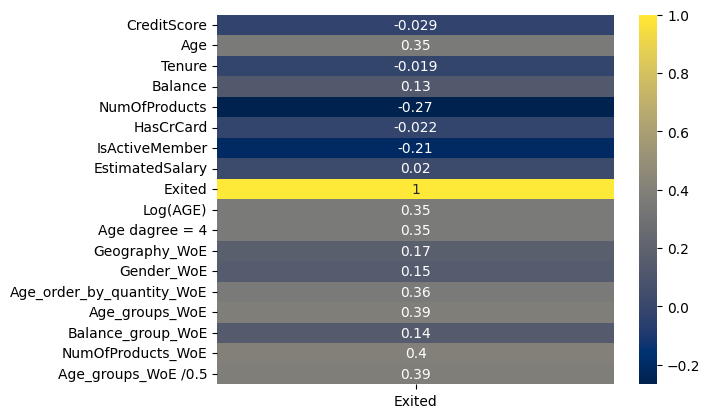

In [146]:
sns.heatmap(df.select_dtypes(include=['number']).corr(method="spearman")[["Exited"]], annot=True, cmap="cividis")


<Axes: >

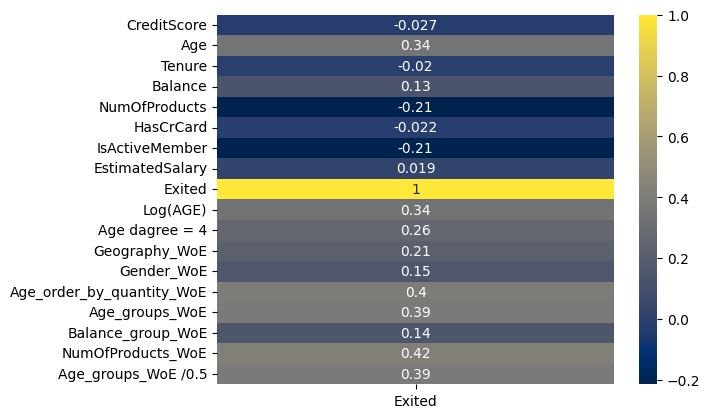

In [147]:
sns.heatmap(df.select_dtypes(include=['number']).corr(method="pearson")[["Exited"]], annot=True, cmap="cividis")


In [148]:
X = df.select_dtypes(include=['number']).drop(['Exited', 'Tenure'], axis=1)
y = df['Exited']
t = 0.8885039188961106  # Bu yerda ROC-AUCning minimal threshold qiymatini belgiladingiz 0.005, 0.0123 0.8885262446846243

# for i in range(1, 20_000):
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(penalty="l2" , C=0.0123))
])


pipeline.fit(X, y)

# pred = pipeline.predict_proba(test)[:, 1]

# ras = roc_auc_score(y_test, pred)

# Xatoni tuzatish: 'max' o'rniga 't' yoki boshqa o'zgaruvchi nomi ishlatilmoqda
    


Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.0123))])

In [149]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# model.fit(X_train, y_train)

# pred = pipeline.predict_proba(X_test)[:,1]

# ras = roc_auc_score(y_test, pred)

In [150]:
# estimators = [
#     ('lr_l1', LogisticRegression(penalty='l1', solver='liblinear')),
#     ('lr_l2', LogisticRegression(penalty='l2')),
#     ('ridge', RidgeClassifier())
# ]

# # Define the stacking classifier
# stacking_clf = StackingClassifier(
#     estimators=estimators,
#     final_estimator=LogisticRegression(penalty='l2'),
#     cv=5
# )

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'lr_l1__C': [9.0, 10.0, 11.0],   # Regularization for Logistic Regression with L1
#     'lr_l2__C': [0.1, 1, 2],       # Regularization for Logistic Regression with L2
#     'ridge__alpha': [0.1, 1, 2]    # Regularization for Ridge Classifier
# }

# grid_search = GridSearchCV(estimator=stacking_clf, param_grid=param_grid, scoring='roc_auc')

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters and corresponding ROC AUC score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Output the results
# print("Best Hyperparameters:", best_params)
# print("Best ROC AUC Score:", best_score)

# # Evaluate the best model on the test set
# best_model = grid_search.best_estimator_
# test_score = roc_auc_score(y_test, best_model.predict(X_test))
# print("Test ROC AUC Score:", test_score)

In [151]:
# print(ras, 0.8883665637113023 <= t, t - 0.8883665637113023)

In [159]:
sub = pd.read_csv("submission.csv", index_col=0)
sub["Exited"] = pipeline.predict_proba(test.select_dtypes(include=['number']).drop(['Tenure'], axis=1))[:,1]


sub.to_csv("sub.csv")

In [153]:
len(test)

110023